Вроде бы задание выполнил, часть с исследовательским анализом мне кажется нормальной, насчет обучения модели не уверен (целевое значение достигнуто, но есть дыры в понимании - их ближе к делу описал). Что писать в финальном выводе не вполне понимал - решил посмотреть на результаты в контексте статьи приложенной к проекту.

# Определение возраста покупателей

# Описание исследования

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

**Цели рабты:**

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

- Контролировать добросовестность кассиров при продаже алкоголя.

**Задача, с помощью которй планируется достичь цели:**

Построить модель, которая по фотографии определит приблизительный возраст человека. Исходные данные набор фотографий людей с указанием возраста.


# Описание данных

Данные взяты с сайта ChaLearn Looking at People. Они находятся в папке /datasets/faces/.

Доступна одна папка со всеми изображениями (/final_files) и csv-файл labels.csv с двумя колонками: file_name и real_age.  

(насколько я понял по ходу выполнения работы это несколько урезанная часть APPA-REAL database)

# Схема выполнения исследования
- [1. Исследовательский анализ данных](#step_1) - проведу первичное исследование фотографий и целевого признака (возраста) 
- [2. Обучение модели](#step_2) - проведу обучение модели в GPU-тренажере до достижения целевой метрики
- [3. Анализ обученной модели](#step_3) - по итогам двух предыдущих шагов постараюсь сделать вывод о результатах, и о том как результаты соответствуют целям исследования

<a id='step_1'></a>
## Исследовательский анализ данных

In [1]:
# ячейка импорта (здесь то что потребовалось на шаге 1)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from PIL import Image

Сначала хочу посмотреть на, то как работает загрузчик - имел в виду тренажер (ну и в подсказку посмотрел раз она есть) - сделал как в подсказке, только target_size сделал меньше + x_col и y_col в тренажере не встречались

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


видно, что всего 7591 картинок

In [3]:
# выделю признаки и целевой признак, как было показано в тренажере методом next
features, target = next(train_gen_flow)

In [4]:
# смотрю на размеры выборок
features.shape

(32, 150, 150, 3)

In [5]:
target.shape

(32,)

дальше (примерно так же как в тренажере выведу 16 фотографий, решил добавть в title значение возраста)

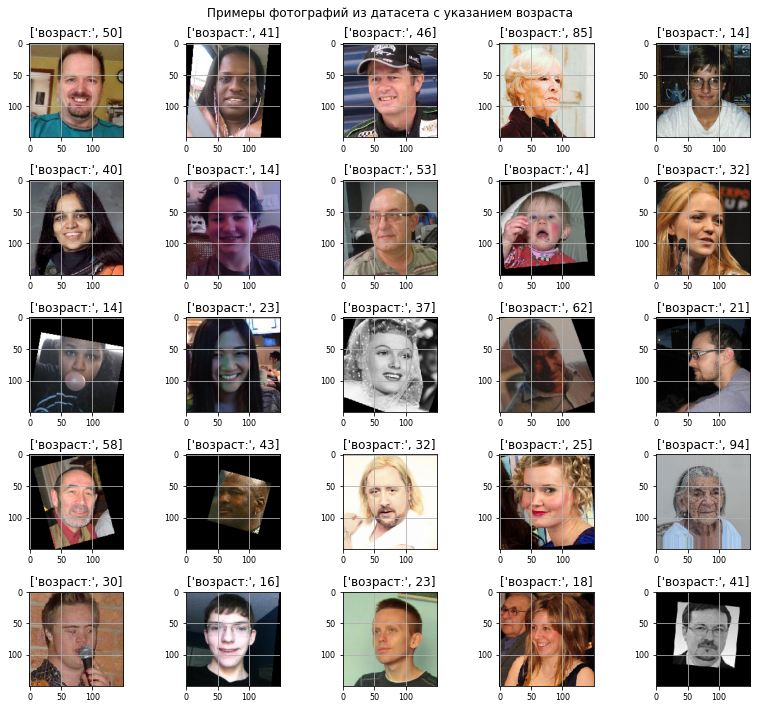

In [21]:
fig = plt.figure(figsize=(12,10))
plt.suptitle('Примеры фотографий из датасета с указанием возраста', size=12)

plt.rc('font', size=10) 
plt.rc('xtick', labelsize=8)    
plt.rc('ytick', labelsize=8) 

for i in range(25):
    fig.add_subplot(5, 5, i+1)
    plt.imshow(features[i])
    plt.xticks()
    plt.yticks()
    plt.grid()
    plt.title(['возраст:', target[i]])
    plt.tight_layout()

Дальше хочу посмотреть на гистограмму возрастов и диаграмму размаха для этого батча (как я понял здесь next выдал один батч), потом это же хочу сделать для всей выборки сначала еще выведу описание методом describe

In [22]:
pd.Series(target).describe()

count    32.000000
mean     35.468750
std      21.741864
min       4.000000
25%      20.250000
50%      31.000000
75%      43.750000
max      94.000000
dtype: float64

Text(0.5, 1.0, 'Диаграмма размаха возрастов')

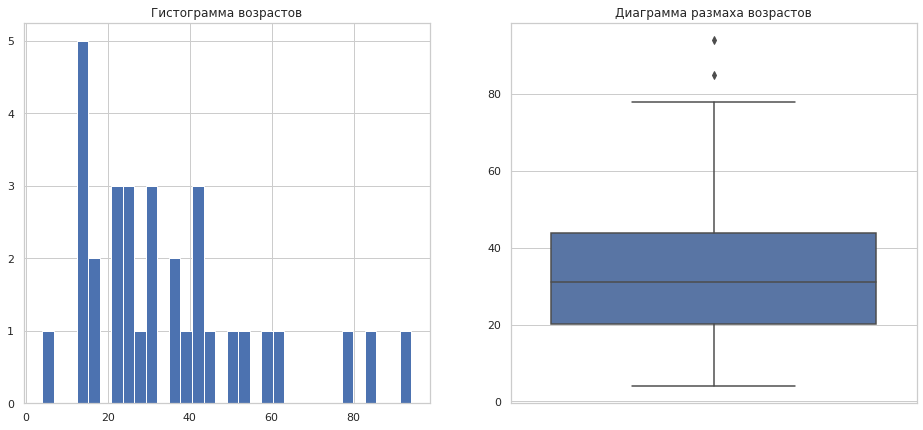

In [23]:
plt.figure(figsize=(16, 7))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)

plt.subplot(1, 2, 1)
pd.Series(target).hist(bins=32)
plt.title('Гистограмма возрастов')

plt.subplot(1, 2, 2)
sns.boxplot(y=pd.Series(target))
plt.title('Диаграмма размаха возрастов')

Что-то видно, на диаграмме размаха лучше, но думаю, что лучше посмотреть в общем на выборку

In [24]:
# размеры выборки
labels.shape

(7591, 2)

<font color='darkblue'> Выборка не очень большая и уже на примере батча видно что разные возраста представлены по разному
</font>
</div>

In [27]:
# посмотрю как выглядит файл с метками
labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


ориентируюясь на имя файла можно вызвать какое-то фото (хотя не думаю, что это особо понадобится)  
дальше посмотрю на гистограмму и диаграмму размаха для всех меток и describe()

In [28]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Text(0.5, 1.0, 'Диаграмма размаха возрастов')

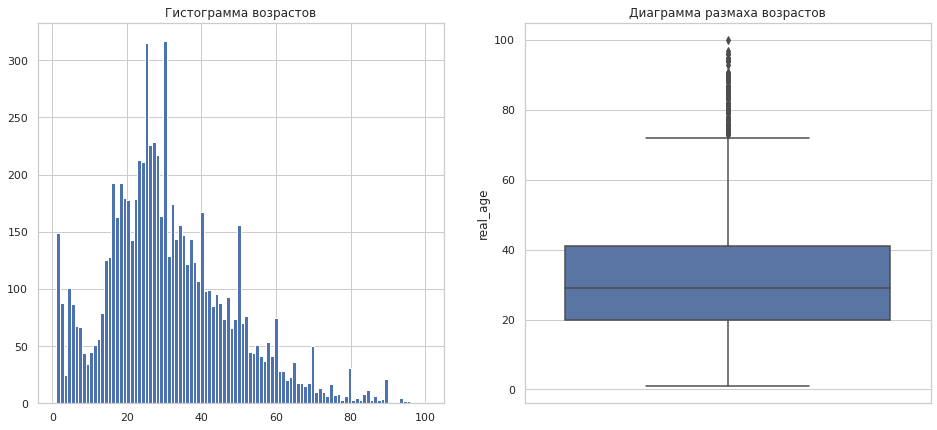

In [29]:
plt.figure(figsize=(16, 7))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)

plt.subplot(1, 2, 1)
labels['real_age'].hist(bins=100)
plt.title('Гистограмма возрастов')

plt.subplot(1, 2, 2)
sns.boxplot(y=labels['real_age'])
plt.title('Диаграмма размаха возрастов')

поставил 100 корзин. Часть данных людей (люди с большим возрастом) выходят за границы усов и могут восприниматься, как выбросы (но скорее всего это реальные данные - фотографий людей большого возраста меньше)
    
    
На гистограмме видно, что сильно выделяется число фото младенцев (1 год), кроме того сейчас обратил внимание, на то что выделяющиеся пики на гистограмме обладают регулярностью (каждые 10 лет число фотографий характеризуется пиком, этого нет для 20 лет, но есть для 25), заметно, что фотографий людей возраста 90 лет намного больше чем в любом возрасте от 80 до 90 (да в общем и от 70 до 80, если не включать собственно 70 и 80)  
    
    
    
Думаю, что это может быть связано с тем, что датасет собирали из нескольких и в одном из них возраст был проранжирован по декадам (хотя это было бы странным, т.к. он явно использовался для серьезных исследовательских работ). Если бы речь шла про "кажущийся" возраст это было бы логичнее (т.к. при оценках люди возмжоно привязываются к каким-то круглым датам), но здесь данные именно по реальному возрасту. В общем мне это кажется странным, но более весомых предположений у меня пока нет.
    


In [13]:
# посмотрю нету ли там дубликатов (маловероятно, но все же)
labels.duplicated().sum()

0

видно, что средний возраст 31, медианный 29. Данные от 1 до 100 лет, в границах усов данные от 1 до примерно 75 - дальше данных меньше. Кажется немного странным провал в детском возрасте - посмотрю с value_counts

In [14]:
labels['real_age'].value_counts().sort_index().head(25)

1     149
2      88
3      25
4     101
5      87
6      68
7      67
8      44
9      34
10     45
11     51
12     56
13     79
14    125
15    128
16    193
17    163
18    193
19    180
20    178
21    143
22    179
23    213
24    211
25    315
Name: real_age, dtype: int64

In [15]:
# хочу попробовать вывести одно фото (в тренажере это было) попробую фотографию самого возрастного человека
labels.query('real_age == 100')

,file_name,real_age
2661,002661.jpg,100


In [16]:
single_image = Image.open('/datasets/faces/final_files/002661.jpg')

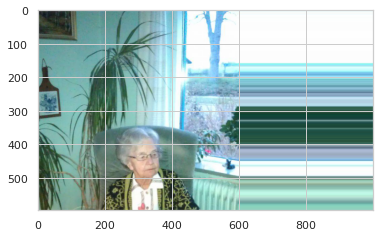

In [17]:
array_single_image = np.array(single_image)

plt.imshow(array_single_image) 

### Вывод по шагу

Снижение фотографий с возрастом выглядит естественно (хотя сложно сказать откуда собирался датасет и как он соотносится с возрастной структурой тех стран где он собран). Скорее всего распределение возрастов как-то связано с доступностью (распространенностью фото разных возрастов), провал в детских фото не совсем понимаю как объяснить. 

Множество фото 1 года кажется естственным - ребенок родился - его постоянно фоткают. Дальше начинают фотографировать меньше, а к подростковому возрасту дети уже начинают сами себя фотографировать больше это складывается с тем, что их фотографируют родители и дальше только растет, до того возраста когда люди начинают стареть фото становятся более формальными (+ возрастная структура).

Еще думал про фактор распространение простых фотосистем (телефонов) и переход с аналоговой фотографии на цифровую (но думаю, что здесь это не имеет значения) 

Исходя из такого распределения скорее всего точнее будет определяться между 14 и 40 годами (и 1 год) а в остальных участках хуже, после 60 еще хуже и после 80 еще.



### Дополнение
Посмотрел на приложенную к проекту статью:

там тоже 7591 значений и график распределения возраста на fig2 очень похож - поэтому предполагаю, что работа идет с упоминающейся в статье APPA-REAL database

я понял, что основной особенностью этой базы является использование реального и "кажущегося" возраста, но в нашем случае работа идет только с реальным

ничего относившегося к моим размешлениям в ячейке выше (про провал в дестком возрасте и то насколько хорошо модель будет работать для разных возрастов) не нашел. Я понял, что основная идея статьи в том что данные по разнице между реальным и кажущимся возрастом в итоге приведет к улучшению оценки и того и того.
Интересный момент виден на рисунке 3 (и описан) - молодые стараются выглядеть более "зрелыми" пожилые наоборот (хотя мне показалось, что на участке 35-50 лет реальный и "кажущийся возраст в основном сходны")

### Дополнение после ревью

<font color='darkblue'> Из тех фотографий, что отображены на графике (как я понимаю случайная выборка) видно, что большая часть фотографий цветные, сделаны в естественной обстановке (с реальным фоном), выровнены прямо (причем судя по всему иногда выравнивали изначально наклонные изображения), лицо на них занимает большую часть изображения.
    
В то же время на этой (небольшой выборке) видны и исключения - черно-белые фото, фото где лицо занимает небольшую площадь, фото где лицо сильно наклонено, фото в профиль, фото с черным фоном (часто после наклона).
    
Думаю, что все эти факторы должны ухудшить работу модели, наверное черно-белые фото можно расцветить, но скорее всего это отдельная задача (особенно если делать её автоматизировано), так же как и поворот. В то же время (с учетом того, что такие фото распространенны даже в небольшой выборке) возможно присутствие такого разнообразия повлияет положительно.
    
Предполагаю, что "кластеры" с увеличением числа фото примерно раз в десять лет тоже не являются хорошим фактором (лучше если было бы равномернее), в то же время конкретно для этой задачи валидационная выборка берется из исходного датасета и (судя по тому, что там достигается +- неплохое mae) можно предположить, что модель отличает эти кластеры. 
    
    
</font>
</div>

<font color='darkblue'> Постарался указать в дополнении к выводу - в общем есть все варианты, но сомневаюсь (скорее не понимаю как их можно унифицировать для данной задачи (т.е. наверное можно, но это будут отдельные задчи - раскраска, поворот - или вести речь о ручной работе?). Плюс, то что в модели используются аугментации скорее всего (по крайней мере в рамках поворота) даст положительный эффект?
    
    
</font>
</div>

<a id='step_2'></a>
## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

В этои части, к сожалению, остается ряд малопонятных мне действий - опирался в основном на то, что делал в тренажере (по крайней мере сама модель почти полностью соответствует последнему заданию, то как менять метрики смотрел в документации к keras, хотя видимо это и проще было можно сделать), но и тред в слаке смотрел (а пока делал задания в тренажере - смотрел туда много). 

Основной момент (хотя не единственный), который я в этом коде плохо понимаю (и плохо понимал на этапе тренажера) - это как результат загрузчиков передается в train_model. Т.е. загрузчики выводят результат (здесь train_dg и test_dg), а функция train_model принимает train_data и test_data - и в какой момент и откуда train_data и test_data берутся? (пробовал разные варианты кода и в каких-то версиях подставлял в train_model загрузчики, но ничего не получалось - поэтому ориентировался на варианты кода обсуждаемые в слаке)


```python

# -*- coding: utf-8 -*-
"""Untitled2.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1UNvws5o-AK5U-U41-ZTYxGz_8e_E-0Ml
"""

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator 

from tensorflow.keras.applications.resnet import ResNet50 

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split = 0.25,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 rotation_range=90,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2)

    train_dg = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        batch_size=16,
        target_size=(224, 224),
        class_mode='raw',
        subset='training',
        seed=12345) 

    return train_dg


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')

    test_datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split = 0.25)

    test_dg = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        batch_size=16,
        target_size=(224, 224),
        class_mode='raw',
        subset='validation',
        seed=12345) 

    return test_dg

def create_model(input_shape):

    optimizer = Adam(lr=0.0001)

    backbone = ResNet50(input_shape=(224, 224, 3),
                    weights='imagenet', 
                    include_top=False)


    model = Sequential()

    model.add(backbone)

    model.add(GlobalAveragePooling2D())

    model.add(Dense(50, activation='relu')) 

    model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError(), 
              metrics=[tf.keras.metrics.MeanAbsoluteError()]) 

    return model 

def train_model(model, train_data, test_data, epochs=5, batch_size=None, steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)  

    if validation_steps is None:
        validation_steps = len(test_data) 

    model.fit(train_data,
              
    batch_size = batch_size,
              
    validation_data = test_data,
    
    epochs=epochs,
              
    steps_per_epoch=steps_per_epoch,

    validation_steps = validation_steps,

    verbose=2, shuffle=True)


    return model


```

сделал следующие изменения:

- vertical_flip убрал
- rotation_range поставил = 10
- решил попробовать сделать больше эпох (8) - в начале исходно делал больше, но в том варианте, который достиг целевой метрики пробовал 5, т.к. пробовал варианты
- еще попробовал в полносвязном слое поставить Dense 101
    
Получилось MAE - 6.37 
    
Скопирую вывод в эту ячейку:
    
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/8
2022-07-12 21:45:55.565848: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-07-12 21:45:57.619718: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 116s - loss: 319.4561 - mean_absolute_error: 13.0468 - val_loss: 855.1277 - val_mean_absolute_error: 24.3586
Epoch 2/8
356/356 - 88s - loss: 106.8819 - mean_absolute_error: 7.8583 - val_loss: 209.5811 - val_mean_absolute_error: 10.7186
Epoch 3/8
356/356 - 89s - loss: 87.6810 - mean_absolute_error: 7.0858 - val_loss: 125.9050 - val_mean_absolute_error: 8.0746
Epoch 4/8
356/356 - 88s - loss: 76.8377 - mean_absolute_error: 6.6967 - val_loss: 88.7493 - val_mean_absolute_error: 7.1729
Epoch 5/8
356/356 - 88s - loss: 61.0166 - mean_absolute_error: 6.0005 - val_loss: 108.7142 - val_mean_absolute_error: 7.5165
Epoch 6/8
356/356 - 88s - loss: 56.7189 - mean_absolute_error: 5.7640 - val_loss: 78.1157 - val_mean_absolute_error: 6.4737
Epoch 7/8
356/356 - 88s - loss: 49.6345 - mean_absolute_error: 5.4189 - val_loss: 112.3194 - val_mean_absolute_error: 8.1433
Epoch 8/8
356/356 - 88s - loss: 45.4636 - mean_absolute_error: 5.1492 - val_loss: 77.0763 - val_mean_absolute_error: 6.3746
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 77.0763 - mean_absolute_error: 6.3746
Test MAE: 6.3746

    


<font color='darkblue'> Еще для более полного ответа на одну из целей задания (про продажу алкоголя) решил попробовать сделать все то же с теми же параметрами, но ограничив группу по возрасту -  **labels = labels.query('real_age > 15 and real_age < 35')**
    
Не знаю насколько корректен такой подход (выборка становится намного меньше), но в то же время, если модель работает лучше внутри такого возрастного интервала, то можно предположить, что она будет полезна в рамках контроля возрасат при продаже алкоголя - здесь MAE получилось 4.01 :  
    
    
Using TensorFlow backend.
Found 2793 validated image filenames.
Found 931 validated image filenames.
    
Train for 175 steps, validate for 59 steps
Epoch 1/8
2022-07-12 22:06:12.998614: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-07-12 22:06:16.583344: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
175/175 - 98s - loss: 158.5826 - mean_absolute_error: 9.6159 - val_loss: 407.6402 - val_mean_absolute_error: 19.5056
Epoch 2/8
175/175 - 45s - loss: 25.6716 - mean_absolute_error: 4.2362 - val_loss: 120.9844 - val_mean_absolute_error: 9.7090
Epoch 3/8
175/175 - 45s - loss: 23.1930 - mean_absolute_error: 3.9951 - val_loss: 40.6601 - val_mean_absolute_error: 5.2892
Epoch 4/8
175/175 - 45s - loss: 20.8722 - mean_absolute_error: 3.7852 - val_loss: 26.7899 - val_mean_absolute_error: 4.2972
Epoch 5/8
175/175 - 45s - loss: 18.3260 - mean_absolute_error: 3.4985 - val_loss: 27.6954 - val_mean_absolute_error: 4.3628
Epoch 6/8
175/175 - 45s - loss: 15.9249 - mean_absolute_error: 3.2415 - val_loss: 23.7041 - val_mean_absolute_error: 4.0466
Epoch 7/8
175/175 - 45s - loss: 14.4203 - mean_absolute_error: 3.0741 - val_loss: 38.9913 - val_mean_absolute_error: 5.1265
Epoch 8/8
175/175 - 45s - loss: 11.8676 - mean_absolute_error: 2.7644 - val_loss: 25.1211 - val_mean_absolute_error: 4.0080
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
59/59 - 5s - loss: 25.1211 - mean_absolute_error: 4.0080
Test MAE: 4.0080
    
</font>
</div>

```

# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >

2022-07-12 11:07:34.210131: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2022-07-12 11:07:34.211981: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.

2022-07-12 11:07:36.410616: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/5
2022-07-12 11:07:50.915032: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-07-12 11:07:51.224604: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 121s - loss: 362.8791 - mean_absolute_error: 14.1992 - val_loss: 681.4843 - val_mean_absolute_error: 21.0943
Epoch 2/5
356/356 - 92s - loss: 155.6457 - mean_absolute_error: 9.5335 - val_loss: 156.5971 - val_mean_absolute_error: 9.8127
Epoch 3/5
356/356 - 91s - loss: 138.1765 - mean_absolute_error: 8.9669 - val_loss: 148.6209 - val_mean_absolute_error: 9.2609
Epoch 4/5
356/356 - 92s - loss: 128.7236 - mean_absolute_error: 8.6923 - val_loss: 125.0842 - val_mean_absolute_error: 8.4163
Epoch 5/5
356/356 - 92s - loss: 118.5795 - mean_absolute_error: 8.3514 - val_loss: 107.7193 - val_mean_absolute_error: 7.7712
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 107.7193 - mean_absolute_error: 7.7712
Test MAE: 7.7712



```

<a id='step_3'></a>
## Анализ обученной модели

Исходно не знаю, что можно сказать сверх того, что получилось достичь MAE 7.77, используя ResNet50.
Думаю, что можно попытаться обусудить результат в сопоставлении с данными приложенной к проекту статьи (датасет, из которой явно используется здесь).

Значения метрик в статье явно лучше (думаю общая разница объясняется, тем что там исследование более продумано и детализировано), хотя для реального возраста модель в статье работает не так хорошо, как для "кажущегося" - но это кажется логичным. 

После того как код стал работать пробовал разные варианты (целевых значений достиг в этом) - input_shape увелилчил до (224, 224, 3), хотя исходно пробовал 150,150; в обучающем наборе расположил досаточно много аугментаций, хотя целевое значение получилось в том варианте когда понизил learning_rate в Adam до 0.0001.

<font color='darkblue'> С учетом корректировок после ревью MAE достигла 6.37. Думаю, что модель неплохо должна справиться с первой задачей (Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы). Вероятно (хотя не вполне уверен в правильности своего подхода) со второй задачей (Контролировать добросовестность кассиров при продаже алкоголя) модель должна справится лучше (я выделил группу между 15 и 35 годам - для ней получилось равной 4.01).    
    
</font>
</div>